<img src="img/ENSAE_logo.jpg">

# *ELTDM Project*
# *Parallelised Community Detection with Spark MapReduce*  
**Mastère Spécialisé Data Science, 2018-19, "Éléments logiciels pour le traitement des données massives"** 
  
**Alban CHAMPEVILLE DE BOISJOLLY**   
**Yosuke IJIRI**  
  

In [15]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## 0. Abstract

This project implements a parallelised community detection algorithm proposed by [*"S. Moon, et al., Parallel community detection on large graphs with MapReduce and GraphChi, Data Knowl. Eng. (2015)"*.](http://dx.doi.org/10.1016/j.datak.2015.05.001) The model is based on Girvan-Newman Algorithm. We use Python, Spark and AWS as the environment.

## 1. Introduction

Analysing network datum has become a key issue in many areas to base suggestions, advices and strategies in many sectors and applications. Community detection aims at identifying clusters in a network, i.e. regroup vertices into groups of high density connected vertices i.a. to make friends recommendations or target marketing. The Girvan-Newman algorithm is one of the most used for this objective. It uses the concept of edge betweenness, which is a measure of the centrality and influence of an edge in a network, with the shortest-path method.

Given the size of networks and the method used to compute the edge betweenness, parallelization of the computation is unavoidable to realize the task efficiently. Our work is focused on the Shortest-Path Betweeness MapReduce Algorithm (SPB-MRA). Parallelizing computations will be realized at each of the 4 stages of the Map-Reduce algorithm.

Related article:  " Parallel community detection on large graphs with MapReduce and GraphChi" published in 2015 by Seunghyeon Moon, Jae-Gil Lee, Minseo Kang, Minsoo Choy and Jin-woo Lee.

## 2. Model

Community Detection, Modularity Method

## 3. Algorithm

Girvan-Newman Algorithm

<img src="img/algo.png" width="400" align="left">

## 4. Data

Stanford Large Network Dataset Collection (https://snap.stanford.edu/data/)

## 5. Environment

Python + Spark on single laptop

Hardware Specification  
CPU: 2.6GHz dual core, Intel Core i5 processor  
Memory: 8GB 1600 MHz DDR3  
OS: macOS Mojave, Version 10.14.2  

## 6. Implementation

Here is the code:

In [16]:
import numpy as np
import pandas as pd

In [17]:
import os
os.getcwd()

'/Users/IjiriYosuke/Documents/GitHub/ELTDM-Project'

In [18]:
# Read the data
data = np.loadtxt("./Data/test.txt", dtype='uint16')
#data = np.loadtxt("./Data/ca-GrQc_small.txt", dtype='uint16')
#data = np.loadtxt("./Data/email-Eu-core.txt", dtype='uint16')
#data = np.loadtxt("./Data/soc-ANU-residence_without_weights.txt", dtype='uint16')
#data = np.loadtxt("./Data/soc-physicians.txt", dtype='uint16')
#data = np.loadtxt("./Data/soc-karate.txt", dtype='uint16')

#print(data)
print(type(data))

<class 'numpy.ndarray'>


### Spark Configuration

In [19]:
try:
    sc.stop()
except NameError:
    pass

from copy import deepcopy  # For making a deep copy of tuple
from itertools import groupby
from pyspark import SparkContext, SparkConf
conf = (SparkConf()
        .setMaster("local[2]")
        .setAppName("ELTDM")
        .set('spark.executor.memory', '10g')
        .set('spark.driver.memory', '10g'))
sc = SparkContext(conf = conf)
sc

<SparkContext master=local[2] appName=ELTDM>

In [20]:
sc._conf.getAll()

[('spark.driver.port', '50857'),
 ('spark.app.name', 'ELTDM'),
 ('spark.rdd.compress', 'True'),
 ('spark.executor.memory', '10g'),
 ('spark.driver.host', '10.21.1.74'),
 ('spark.app.id', 'local-1545503217944'),
 ('spark.driver.memory', '10g'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.master', 'local[2]')]

In [21]:
sc.defaultParallelism

2

In [22]:
# Clean up edges
d = sc.parallelize(data)#.repartition(sc.defaultParallelism * 3)
d = d.map(lambda x: x if x[0] < x[1] else [x[1], x[0]]).filter(lambda x: x[0] != x[1]).collect()  # remove edge between a sigle node and prepare to remove duplicate edges
d = set(map(tuple, d))  # Remove duplicate edges
d = list(d)
d = list(map(list, d))

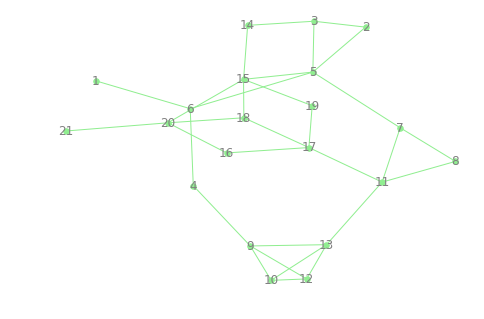

In [23]:
#Visualisation of the graph
import pandas
import networkx as nx
import matplotlib.pyplot as plt

nodes = set([n1 for n1, n2 in d] + [n2 for n1, n2 in d])  # We keep this original node list during the whole process
nsize=30
import time
def draw_graph(graph):
    # extract nodes from graph
    #nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])
    # create networkx graph
    G=nx.Graph()
    # add nodes
    for node in nodes:
        G.add_node(node)
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
    # draw graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels = True, node_size=nsize, node_color='lightgreen', edge_color='lightgreen', font_color='gray')
    # show graph
    t = float(time.time())
    plt.savefig('./Data/Figures/Pre_Round1.png')
    plt.show()
np.random.seed(seed=1234) 
draw_graph(data)

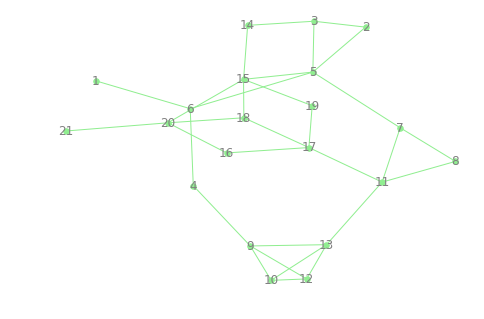

In [24]:
np.random.seed(seed=1234)  # Same position for the same graph
draw_graph(data)

In [25]:
nodeId = np.unique(d)
nrow = len(d)
nb_edges_initial = nrow
print("The data contains")
print(len(nodeId), "distinct nodes, and", nrow, "distinct edges")

The data contains
21 distinct nodes, and 31 distinct edges


In [26]:
# Make a list of adjacency lists (first element is the node of origin)
adj_list = []
for n in nodeId:
    adj = []
    for i in range(nrow):
        if d[i][0] == n:
            adj.append(d[i][1])
        if d[i][1] == n:
            adj.append(d[i][0])
    adj = list(set(adj)) 
    adj.insert(0, n)
    adj_list.append(adj)
#print(adj_list)

In [27]:
# Make tuple for each node
class tuples():
    def __init__(self, targetId, sourceId, distance, status, weight, pathInfo, adjList) :
        self.targetId = targetId
        self.sourceId = sourceId
        self.distance = distance
        self.status = status
        self.weight = weight
        self.pathInfo = pathInfo
        self.adjList = adjList

network = []
for n in nodeId:
    v = tuples(targetId = n, sourceId = n, distance = 0, status = 'a', weight = 1, pathInfo = [], adjList = [])
    for i in range(len(adj_list)):
        if adj_list[i][0] == n:
            v.adjList = adj_list[i][1:len(adj_list[i])]
            break
    network.append([v.targetId, v.sourceId, v.distance, v.status, v.weight, v.pathInfo, v.adjList])
#for i in range(len(network)):
#    print(network[i])

### Main Parallelisation part

It might be needed to partion every rdd

In [28]:
# Set a dataset and create key-value pairs
rdd = sc.parallelize(network)#.repartition(sc.defaultParallelism * 3)
rdd = rdd.map(lambda x: (x[0], x[1:]))
output = rdd.collect()

#### Stage 1 - Map 

This part employes Breadth First Search

In [29]:
def stage1_map(p):  
    result = []
    if p[1][2] == 'a':
        p[1][2] = 'i'
        p[1][1] += 1
        p[1][4].append(p[0])
        x = deepcopy(p)
        result.append(x)
        temp = p[1][5].copy()
        for i in range(len(temp)):
            k = temp[i]
            p[1][2] = 'a'
            p[1][5] = []
            y = deepcopy(p)
            result.append((k, y[1]))
        return result
    else:
        els = deepcopy(p)
        result.append(els)
        return result

#### Stage 1 - Reduce 

This part consists of 6 steps:  
1) Add *sourceId* to key  
2) Aggregate the values that belong to the same key  
3) Take only values that have the shortest distance in the same key  
4) Replace *weight* of such values $\in minList$ with the size of $minList$  
5) Flatten values and list the tuples  
6) Fill in any empty adjList

In [30]:
def join(x, y):
    # 4 conditional statements below to join values
    # with correct level of nesting
    if (type(x[0]) is list) and (type(y[0]) is not list):
        return x+[y]
    elif (type(x[0]) is not list) and (type(y[0]) is list):
        return [x]+y
    elif (type(x[0]) is not list) and (type(y[0]) is not list):
        return [x]+[y]
    else:
        return x+y
    isinstance(x[0], int)

In [31]:
def stage1_reduce(x):
    if type(x[1][0]) is list:
        m = x[1][0][0]
        for s in range(len(x[1])):
            if x[1][s][0] < m:
                m = x[1][s][0]
        minList = []
        # Drop tuple(s) with non-shortest distance
        for s in range(len(x[1])):
            if x[1][s][0] == m:
                minList.append(x[1][s])
        y = (x[0], minList)
        # Update weight
        for s in range(len(minList)):
            y[1][s][2] = len(minList)
        return y
    else:
        return x

In [32]:
def twokeys_to_onekey(x):
    k = x[0][0]
    v = [x[0][1]]
    v.extend(x[1])
    return k, v

#### Stage2 - Map & Reduce

In [33]:
from operator import add
def stage2_map(x):
    edges_on_the_path = []
    for i in range(len(x[1][4])-1):
        k = (x[1][4][i], x[1][4][i+1])
        w = x[1][3]
        edges_on_the_path.append((k, 1/w))
    return edges_on_the_path

#### Stage3 - Map & Reduce

#### Stage4 - Map

In [34]:
def stage4_map(x):
    counter = 0
    output = []
    for i in range(len(distributed_cache)):
        if x[0] in distributed_cache[i][0]:
            counter += 1  # Increase counter if its key is affected by the removal of the edge(s)
            c = distributed_cache[i][0][not(distributed_cache[i][0].index(x[0]))]  # Take the corresponding node
            try:
                x[1][5].remove(c)  # Remove if the corresponding node exists in the adjList
            except ValueError:
                pass  # Pass otherwise
    if counter == 0:
        return [tuple(x)]
    else:
        new = (x[1][0], [x[1][0], 0, 'a', 1, [], []])
        return x, new

#### Stage4 - Reduce

In [35]:
def stage4_reduce(x, y):
    if x[2] == 'a' and y[2] == 'a':
        return x
    elif x[2] == 'a' and y[2] == 'i':
        x[5] = y[5].copy()
        return x
    elif x[2] == 'i' and y[2] == 'a':
        y[5] = x[5].copy()
        return y
    else:
        return x+y
def revision(x):  # To flatten the pressed tuples (ones with status i)
    tup = []
    if len(x[1]) > 6:
        for i in range(int(len(x[1])/6)):
            tup.append((x[0],x[1][i*6:i*6+6]))
        return tup
    else:
        return [x]

In [36]:
def from_tuples_to_edgelist(x):
    res = []
    for i in range(len(x)):
        for j in range(len(x[i][1][5])):
            res.append([x[i][0], x[i][1][5][j]])
    res = set(map(tuple, res))  # Remove duplicate edges
    res = list(res)
    result = list(map(list, res))
    return result

In [37]:
#Visualisation of the graph
import pandas
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

nodes = set([n1 for n1, n2 in data] + [n2 for n1, n2 in data])
r = 1
def draw_graph(graph, r):
    # create networkx graph
    G=nx.Graph()
    # add nodes
    for node in nodes:
        G.add_node(node)
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
    # draw graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels = True, node_size=nsize, node_color="lightgreen", edge_color='lightgreen', font_color='gray')
    # show graph
    t = float(time.time())
    plt.savefig('./Data/Figures/Post_Round_%d.png' %r)
    plt.show()

### Modularity Q

$Q=\sum_{i}(e_{ii}-a_i^2) = \mathrm{Tr}\ {\bf e} - \|{\bf e}^2\|$

In [38]:
def Q_modularity(elist, nodes):

# Read and clean up edges
    c = sc.parallelize(elist)
    c = c.map(lambda x: x if x[0] < x[1] else [x[1], x[0]]).filter(lambda x: x[0] != x[1]).collect()  # remove edge between a sigle node and prepare to remove duplicate edges
    c = set(map(tuple, c))  # Remove duplicate edges
    c = list(c)
    c = list(map(list, c))

# Make a graph for NetworkX library
    H=nx.Graph()
    # add nodes
    for node in nodes:
        H.add_node(node)
    # add edges
    for edge in c:
        H.add_edge(edge[0], edge[1])

# Make a community dictionary from the edge list {nodeId: communityId}
    com_dic = {}
    com_id = 0

    for n in nodes:
        try:
            com_dic[n]
        except KeyError:
            com_id += 1
            com_dic[n] = com_id
            for m in nodes:
                if (n != m) and (nx.has_path(H, m, n)):  # has_path(G, source, target): return True if there is a path
                    try:
                        com_dic[m]
                    except KeyError:
                        com_dic[m] = com_id

    com_ids = list(set(com_dic.values()))
    com_ids

# Create a matrix `e` to calculate Q
    e = np.matrix([[0.]*len(com_ids)]*len(com_ids))

# Fill in `e` 
    for i in range(len(com_ids)):
        for j in range(len(com_ids)):
            keys_i = [k for k, v in com_dic.items() if v == i+1]
            keys_j = [k for k, v in com_dic.items() if v == j+1]
            if i == j:  # Fraction of edges that are within the same community
                nb_within = 0
                for edge in c:
                    if set(edge) <= set(keys_i):
                        nb_within += 1
                e[i, i] = nb_within/nb_edges_initial
            elif i < j:  # Fraction of edges that cross between community i and community j
                nb_cross = 0
                for edge in d:
                    if (({edge[0]} <= set(keys_i)) and ({edge[1]} <= set(keys_j))) or (({edge[0]} <= set(keys_j)) and ({edge[1]} <= set(keys_i))):
                        nb_cross += 1
                e[i, j] = nb_cross/nb_edges_initial
                e[j, i] = nb_cross/nb_edges_initial

    a = np.ndarray.sum(e, axis=1)  
    a = np.squeeze(np.asarray(a))

# Calculate Q 
    Q = float(e.trace()) - np.dot(a, a)

    return Q, com_dic

### Rounds Stage1-4

Data contains 21 nodes, and 31 edges 

ROUND 1 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 62 / 83 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 148 / 231 active tuples left. 

Iteration 3 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in ad

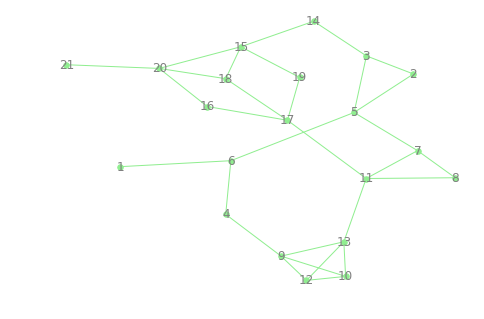

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1}
(There are 1 communities now)
Q Modularity is: 0.031217481789802215
Round 1 took 4.5 seconds ( 0.1 mins)

 

ROUND 2 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 60 / 81 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 132 / 213 act

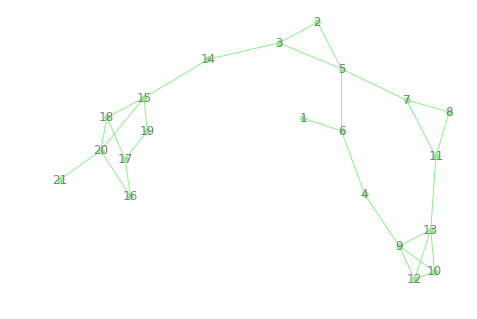

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1}
(There are 1 communities now)
Q Modularity is: 0.060353798126951186
Round 2 took 3.7 seconds ( 0.1 mins)

 

ROUND 3 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 58 / 79 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 120 / 199 act

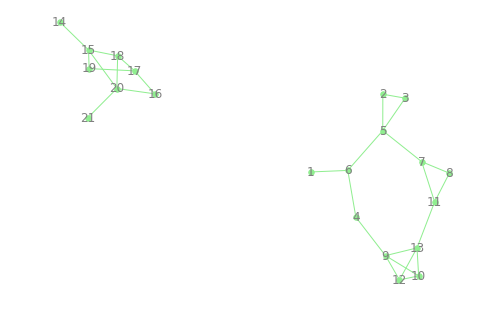

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2}
(There are 2 communities now)
Q Modularity is: 0.2684703433922997
Round 3 took 3.7 seconds ( 0.1 mins)

 

ROUND 4 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 56 / 77 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 114 / 191 activ

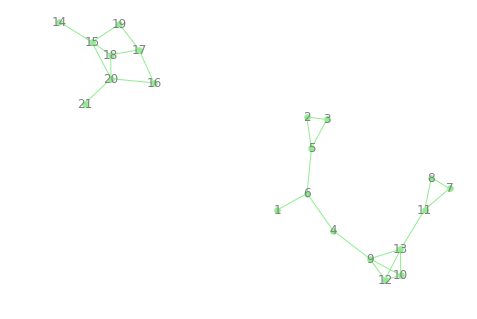

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2}
(There are 2 communities now)
Q Modularity is: 0.278876170655567
Round 4 took 2.0 seconds ( 0.0 mins)

 

ROUND 5 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 34 / 123 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 64 / 187 active

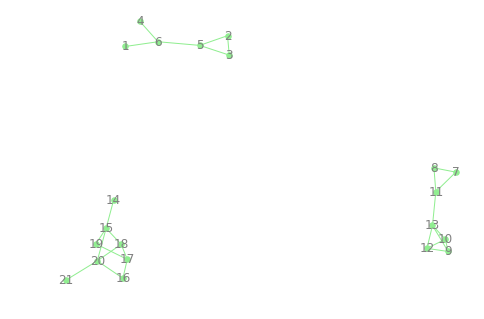

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 3, 21: 3}
(There are 3 communities now)
Q Modularity is: 0.38293444328824144
Round 5 took 1.8 seconds ( 0.0 mins)

 

ROUND 6 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 32 / 121 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 56 / 177 acti

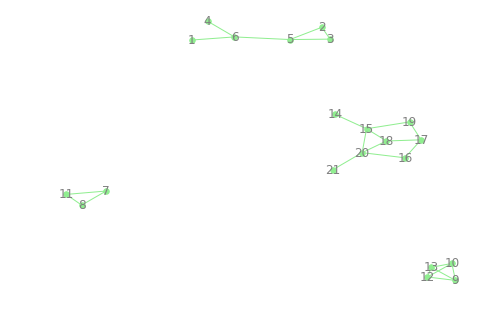

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 11: 2, 9: 3, 10: 3, 12: 3, 13: 3, 14: 4, 15: 4, 16: 4, 17: 4, 18: 4, 19: 4, 20: 4, 21: 4}
(There are 4 communities now)
Q Modularity is: 0.42247658688865763
Round 6 took 1.0 seconds ( 0.0 mins)

 

ROUND 7 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 18 / 137 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 30 / 167 acti

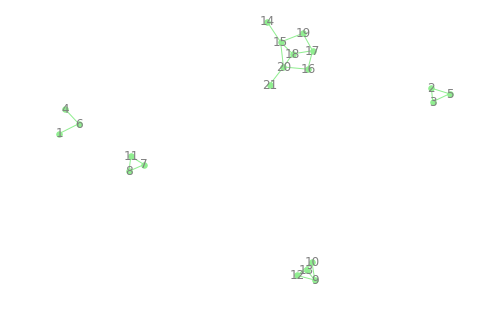

Community Labelling is: {1: 1, 4: 1, 6: 1, 2: 2, 3: 2, 5: 2, 7: 3, 8: 3, 11: 3, 9: 4, 10: 4, 12: 4, 13: 4, 14: 5, 15: 5, 16: 5, 17: 5, 18: 5, 19: 5, 20: 5, 21: 5}
(There are 5 communities now)
Q Modularity is: 0.4266389177939647
Round 7 took 0.9 seconds ( 0.0 mins)

 

ROUND 8 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 10 / 117 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 8 / 125 active

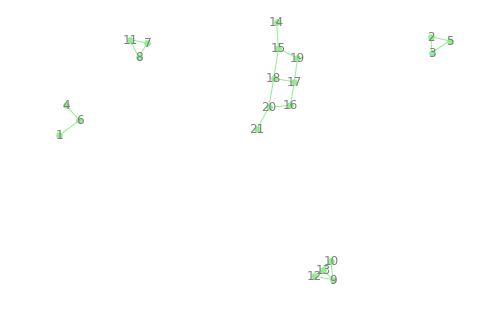

Community Labelling is: {1: 1, 4: 1, 6: 1, 2: 2, 3: 2, 5: 2, 7: 3, 8: 3, 11: 3, 9: 4, 10: 4, 12: 4, 13: 4, 14: 5, 15: 5, 16: 5, 17: 5, 18: 5, 19: 5, 20: 5, 21: 5}
(There are 5 communities now)
Q Modularity is: 0.42039542143600417
Round 8 took 1.0 seconds ( 0.0 mins)

 

ROUND 9 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 18 / 69 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 28 / 97 active

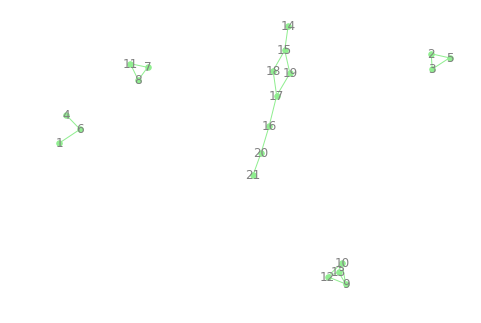

Community Labelling is: {1: 1, 4: 1, 6: 1, 2: 2, 3: 2, 5: 2, 7: 3, 8: 3, 11: 3, 9: 4, 10: 4, 12: 4, 13: 4, 14: 5, 15: 5, 16: 5, 17: 5, 18: 5, 19: 5, 20: 5, 21: 5}
(There are 5 communities now)
Q Modularity is: 0.41207075962539025
Round 9 took 1.1 seconds ( 0.0 mins)

 

ROUND 10 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 16 / 67 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 20 / 87 activ

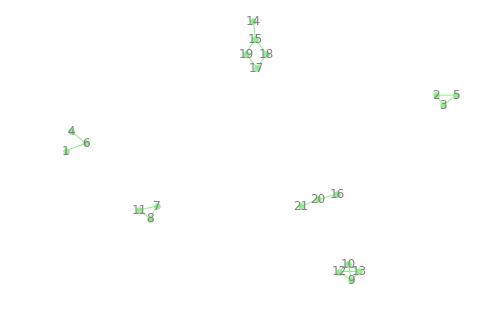

Community Labelling is: {1: 1, 4: 1, 6: 1, 2: 2, 3: 2, 5: 2, 7: 3, 8: 3, 11: 3, 9: 4, 10: 4, 12: 4, 13: 4, 14: 5, 15: 5, 17: 5, 18: 5, 19: 5, 16: 6, 20: 6, 21: 6}
(There are 6 communities now)
Q Modularity is: 0.3537981269510927
Round 10 took 1.3 seconds ( 0.0 mins)

 

ROUND 11 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 14 / 65 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 14 / 79 activ

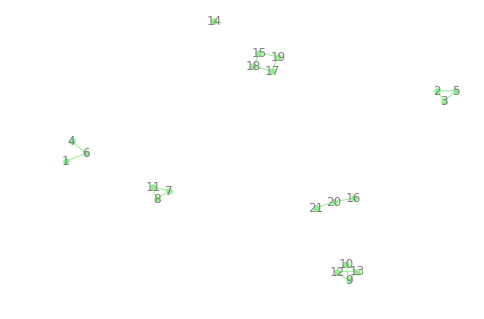

Community Labelling is: {1: 1, 4: 1, 6: 1, 2: 2, 3: 2, 5: 2, 7: 3, 8: 3, 11: 3, 9: 4, 10: 4, 12: 4, 13: 4, 14: 5, 15: 6, 17: 6, 18: 6, 19: 6, 16: 7, 20: 7, 21: 7}
(There are 7 communities now)
Q Modularity is: 0.33922996878251815
Round 11 took 1.0 seconds ( 0.0 mins)

 

ROUND 12 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 8 / 65 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 8 / 73 active

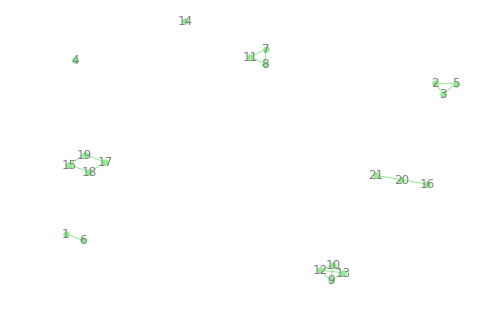

Community Labelling is: {1: 1, 6: 1, 2: 2, 3: 2, 5: 2, 4: 3, 7: 4, 8: 4, 11: 4, 9: 5, 10: 5, 12: 5, 13: 5, 14: 6, 15: 7, 17: 7, 18: 7, 19: 7, 16: 8, 20: 8, 21: 8}
(There are 8 communities now)
Q Modularity is: 0.31009365244536946
Round 12 took 1.2 seconds ( 0.0 mins)

 

ROUND 13 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 2 / 69 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 0 / 69 active

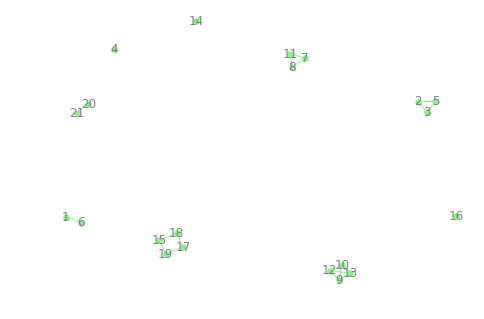

Community Labelling is: {1: 1, 6: 1, 2: 2, 3: 2, 5: 2, 4: 3, 7: 4, 8: 4, 11: 4, 9: 5, 10: 5, 12: 5, 13: 5, 14: 6, 15: 7, 17: 7, 18: 7, 19: 7, 16: 8, 20: 9, 21: 9}
(There are 9 communities now)
Q Modularity is: 0.283038501560874
Round 13 took 0.8 seconds ( 0.0 mins)

 

ROUND 14 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 2 / 65 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 0 / 65 active t

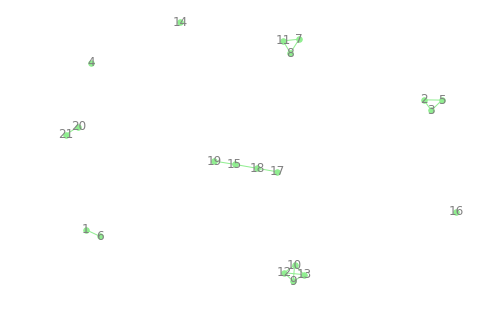

Community Labelling is: {1: 1, 6: 1, 2: 2, 3: 2, 5: 2, 4: 3, 7: 4, 8: 4, 11: 4, 9: 5, 10: 5, 12: 5, 13: 5, 14: 6, 15: 7, 17: 7, 18: 7, 19: 7, 16: 8, 20: 9, 21: 9}
(There are 9 communities now)
Q Modularity is: 0.27055150884495316
Round 14 took 0.7 seconds ( 0.0 mins)

 

ROUND 15 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 6 / 55 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 4 / 59 active

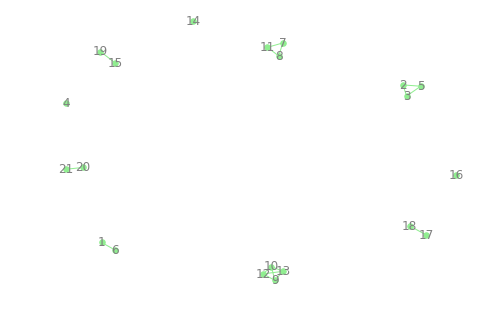

Community Labelling is: {1: 1, 6: 1, 2: 2, 3: 2, 5: 2, 4: 3, 7: 4, 8: 4, 11: 4, 9: 5, 10: 5, 12: 5, 13: 5, 14: 6, 15: 7, 19: 7, 16: 8, 17: 9, 18: 9, 20: 10, 21: 10}
(There are 10 communities now)
Q Modularity is: 0.2476586888657648
Round 15 took 1.4 seconds ( 0.0 mins)

 

ROUND 16 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 4 / 53 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 0 / 53 acti

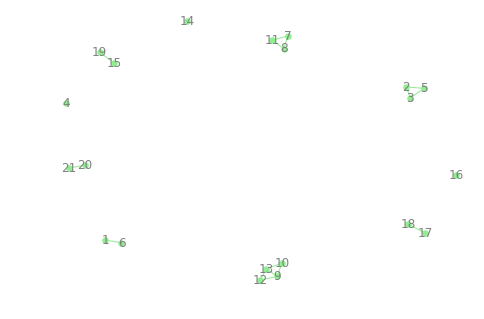

Community Labelling is: {1: 1, 6: 1, 2: 2, 3: 2, 5: 2, 4: 3, 7: 4, 8: 4, 11: 4, 9: 5, 10: 5, 12: 5, 13: 5, 14: 6, 15: 7, 19: 7, 16: 8, 17: 9, 18: 9, 20: 10, 21: 10}
(There are 10 communities now)
Q Modularity is: 0.23100936524453686
Round 16 took 1.3 seconds ( 0.0 mins)

 

ROUND 17 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 10 / 51 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 16 / 67 a

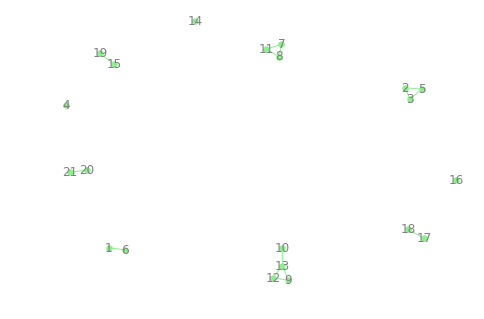

Community Labelling is: {1: 1, 6: 1, 2: 2, 3: 2, 5: 2, 4: 3, 7: 4, 8: 4, 11: 4, 9: 5, 10: 5, 12: 5, 13: 5, 14: 6, 15: 7, 19: 7, 16: 8, 17: 9, 18: 9, 20: 10, 21: 10}
(There are 10 communities now)
Q Modularity is: 0.2122788761706555
Round 17 took 1.5 seconds ( 0.0 mins)

 

ROUND 18 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 8 / 49 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 10 / 59 act

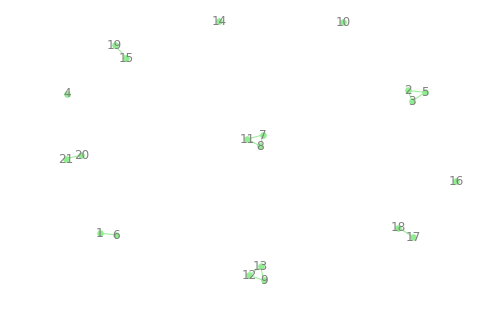

Community Labelling is: {1: 1, 6: 1, 2: 2, 3: 2, 5: 2, 4: 3, 7: 4, 8: 4, 11: 4, 9: 5, 12: 5, 13: 5, 10: 6, 14: 7, 15: 8, 19: 8, 16: 9, 17: 10, 18: 10, 20: 11, 21: 11}
(There are 11 communities now)
Q Modularity is: 0.14151925078043703
Round 18 took 1.4 seconds ( 0.0 mins)

 

ROUND 19 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 6 / 47 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 6 / 53 a

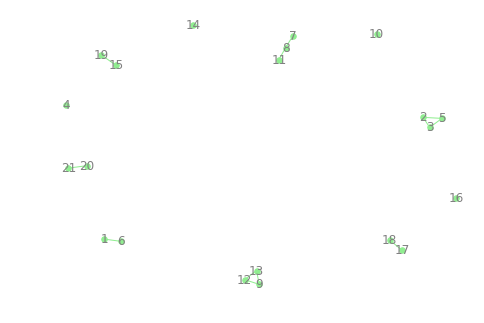

Community Labelling is: {1: 1, 6: 1, 2: 2, 3: 2, 5: 2, 4: 3, 7: 4, 8: 4, 11: 4, 9: 5, 12: 5, 13: 5, 10: 6, 14: 7, 15: 8, 19: 8, 16: 9, 17: 10, 18: 10, 20: 11, 21: 11}
(There are 11 communities now)
Q Modularity is: 0.1207075962539022
Round 19 took 1.3 seconds ( 0.0 mins)

 

ROUND 20 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 4 / 45 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 2 / 47 ac

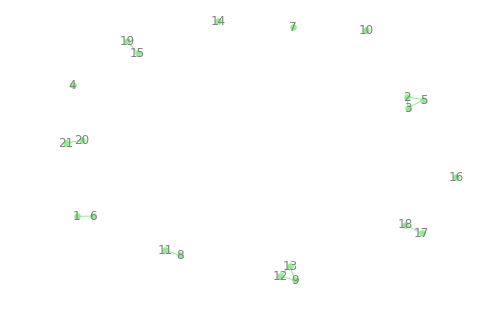

Community Labelling is: {1: 1, 6: 1, 2: 2, 3: 2, 5: 2, 4: 3, 7: 4, 8: 5, 11: 5, 9: 6, 12: 6, 13: 6, 10: 7, 14: 8, 15: 9, 19: 9, 16: 10, 17: 11, 18: 11, 20: 12, 21: 12}
(There are 12 communities now)
Q Modularity is: 0.07908428720083244
Round 20 took 1.1 seconds ( 0.0 mins)

 

ROUND 21 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 2 / 43 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 0 / 43 

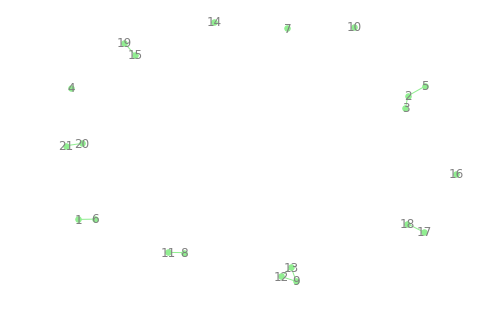

Community Labelling is: {1: 1, 6: 1, 2: 2, 3: 2, 5: 2, 4: 3, 7: 4, 8: 5, 11: 5, 9: 6, 12: 6, 13: 6, 10: 7, 14: 8, 15: 9, 19: 9, 16: 10, 17: 11, 18: 11, 20: 12, 21: 12}
(There are 12 communities now)
Q Modularity is: 0.060353798126951075
Round 21 took 1.3 seconds ( 0.0 mins)

 

ROUND 22 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 4 / 41 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 2 / 43

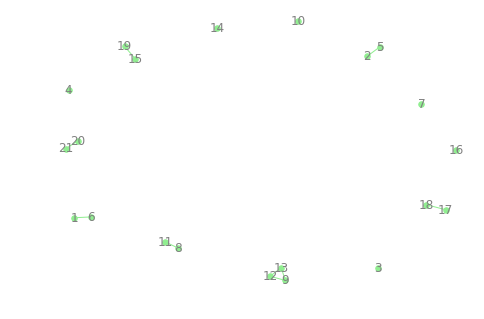

Community Labelling is: {1: 1, 6: 1, 2: 2, 5: 2, 3: 3, 4: 4, 7: 5, 8: 6, 11: 6, 9: 7, 12: 7, 13: 7, 10: 8, 14: 9, 15: 10, 19: 10, 16: 11, 17: 12, 18: 12, 20: 13, 21: 13}
(There are 13 communities now)
Q Modularity is: 0.018730489073881362
Round 22 took 1.2 seconds ( 0.0 mins)

 

ROUND 23 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 2 / 39 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 0 / 

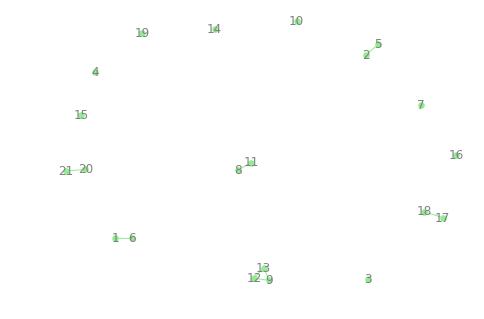

Community Labelling is: {1: 1, 6: 1, 2: 2, 5: 2, 3: 3, 4: 4, 7: 5, 8: 6, 11: 6, 9: 7, 12: 7, 13: 7, 10: 8, 14: 9, 15: 10, 16: 11, 17: 12, 18: 12, 19: 13, 20: 14, 21: 14}
(There are 14 communities now)
Q Modularity is: -0.006243496357960454
Round 23 took 0.8 seconds ( 0.0 mins)

 

Since the Q modularity reached less than 0, we ended the calculations.
All the  23 rounds finished

Total execution time was 36.1 seconds ( 0.6 mins)

Removed edges were [[((5, 15), 49.233333333333334)], [((11, 17), 67.16666666666667)], [((3, 14), 104.0)], [((5, 7), 22.5)], [((4, 9), 42.0)], [((11, 13), 12.0)], [((5, 6), 9.0)], [((15, 20), 8.0)], [((18, 20), 9.5)], [((16, 17), 15.0)], [((14, 15), 4.0)], [((4, 6), 2.0)], [((16, 20), 2.0)], [((17, 19), 2.0)], [((15, 18), 4.0)], [((10, 12), 1.0)], [((9, 10), 1.5)], [((10, 13), 3.0)], [((7, 11), 1.0)], [((7, 8), 2.0)], [((3, 5), 1.0)], [((2, 3), 2.0)], [((15, 19), 1.0)]]
Please check the saved figures under "./Data/Figures"


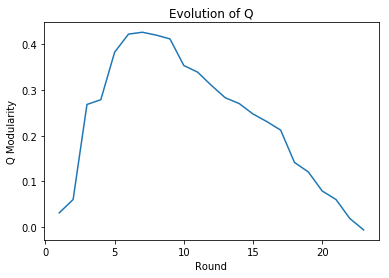

Q list is: [0.031217481789802215, 0.060353798126951186, 0.2684703433922997, 0.278876170655567, 0.38293444328824144, 0.42247658688865763, 0.4266389177939647, 0.42039542143600417, 0.41207075962539025, 0.3537981269510927, 0.33922996878251815, 0.31009365244536946, 0.283038501560874, 0.27055150884495316, 0.2476586888657648, 0.23100936524453686, 0.2122788761706555, 0.14151925078043703, 0.1207075962539022, 0.07908428720083244, 0.060353798126951075, 0.018730489073881362, -0.006243496357960454]

 Maximum Q was achieved at round 7 and the value was 0.4266389177939647
 The best community structure is: {1: 1, 4: 1, 6: 1, 2: 2, 3: 2, 5: 2, 7: 3, 8: 3, 11: 3, 9: 4, 10: 4, 12: 4, 13: 4, 14: 5, 15: 5, 16: 5, 17: 5, 18: 5, 19: 5, 20: 5, 21: 5}
  and there are 5 communities.
 The graph at the best was:


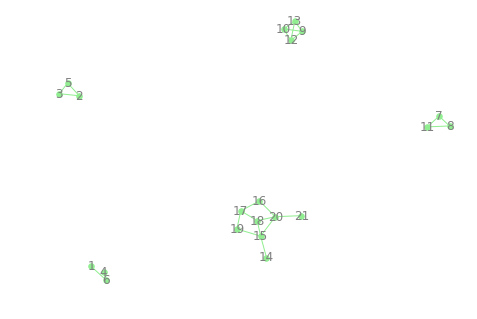

 It took 17.7 seconds ( 0.3 mins) until the network reaches the best community structure.


In [39]:
# Iteration of Stage1-4
import matplotlib.pyplot as plt
import time

print("Data contains", len(nodeId), "nodes, and", nrow, "edges \n")

# Parameter initialisation
k_iter = 1  # Number of edges to be removed at each round. The default value is 1.
r=1
removed_edges=[]
t_initial = time.time()
Q = 0
elist_hist = []
Q_hist = []
community_hist = []
t_hist = []

while Q >= 0:
    print("ROUND", r, "STARTED! \n")
    
# Stage1
    t_start = time.time() 
    # Iteration until status becomes 'i' for all tuples
    act_counter = 1
    ite = 1
    while act_counter > 0:
        print("Iteration", ite, "started...")
        rdd = sc.parallelize(output)#.repartition(sc.defaultParallelism * 3)

    # <stage1 map>
        print(" Now doing Map..")
        pos_map1 = rdd.flatMap(stage1_map)
    # <stage1 reduce>
        print(" Now doing Reduce..")
        red1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
        red1_grouped = red1_twokeys.reduceByKey(join)
        red1_weighted = red1_grouped.map(stage1_reduce)
        print(" Now collecting Reduce result..")
        t1 = time.time()
        record = red1_weighted.map(twokeys_to_onekey).collect()
        t2 = time.time()
        print("  Collecting Reduce result took", round(t2-t1, 1), "seconds (", round((t2-t1)/60, 1), "mins ).")
        print(" Now flattening Reduce result..")
        t3 = time.time()
        
        # 'for' loop to flatten the grouped values (non-parallelized)
        new = []
        for i in range(len(record)):
            if type(record[i][1][1]) is list:
                record[i]
                key = record[i][0]
                srcId = [record[i][1][0]]
                others = record[i][1][1:]
                for j in range(len(others)):
                    s = srcId.copy()
                    o = others[j]
                    s.extend(o)
                    newrec = (key, s)
                    new.append(newrec)
        pos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  # Save records with only one value
        pos_red1.extend(new)  # Add records which had multiple values
        output = pos_red1.copy()
        t4 = time.time()
        print("  Flattening took", round(t4-t3, 1), "seconds (", round((t4-t3)/60, 1), "mins ).")
        print(" Now finalising Reduce result by filling in adjList..")
        # Fill in adjList before going to next iteration
        t5 = time.time()    
        for i in range(len(output)):
            if output[i][1][5] == []:
                for j in range(len(adj_list)):
                    if adj_list[j][0] == output[i][0]:
                        output[i][1][5] = adj_list[j][1:len(adj_list[j])]
                        break
        t6 = time.time()
        print("  Filling in adjList took", round(t6-t5, 1), "seconds (", round((t6-t5)/60, 1), "mins ).")
        print(" Now iteration",ite ,"finished!")
        act_counter = 0
        for i in range(len(output)):
            if output[i][1][2] == 'a':
                act_counter += 1
        print("Iteration", ite, "finished. There are", act_counter, "/", len(output), "active tuples left. \n")
        ite += 1
    stage1_output = output.copy()
    print("All the Stage1 iterations have finished. Stage1 was iterated for", ite-1, "times.")
    #print("Stage1 result is:")  # DELETE AFTER DEBUGGING
    #for i in range(len(stage1_output)):  # DELETE AFTER DEBUGGING
    #    print(stage1_output[i])  # DELETE AFTER DEBUGGING
    t_end = time.time()
    elapsed_time = t_end-t_start
    elapsed_time_min = elapsed_time/60
    print("Stage1 execution time was", round(elapsed_time, 1), "seconds (", round(elapsed_time_min, 1), "mins ).")

# Stage2
    pre_map2 = sc.parallelize(stage1_output)#.repartition(sc.defaultParallelism * 3)
    # Apply Map after filtering out tuples which has single node info and duplicated tuples (as we consider undirected graph network)
    pos_map2 = pre_map2.filter(lambda x: x[0] > x[1][0]).flatMap(stage2_map)
    # Stage2 Reduce
    pos_red2_directed = pos_map2.reduceByKey(add)
    # Ignore the order of node ID at each edge and run reduceByKey(add) again
    pos_red2 = pos_red2_directed.map(lambda x: ((x[0][1], x[0][0]), x[1]) if x[0][0] > x[0][1] else x).reduceByKey(add)

# Stage3
    # Stage3 Map & Reduce
    distributed_cache = pos_red2.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1], x[0])).take(k_iter)
    top10 = pos_red2.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1], x[0])).take(10)
    print("Edge betweenness Score Top 10 is:", top10)   
    print("Round", r, "removes", distributed_cache)
    removed_edges.append(distributed_cache)
    
# Stage4
    pos_map4 = pre_map2.flatMap(stage4_map)
    pos_red4 = pos_map4.reduceByKey(stage4_reduce).flatMap(revision)
    output = pos_red4.collect()
    elist = from_tuples_to_edgelist(output)
    print("After the edge removal, the graph is:")
    np.random.seed(seed=1234)
    draw_graph(elist, r)

# Update adj_list 
    adj_list = []
    for i in range(len(output)):
        targ = [output[i][0]]
        targ.extend(output[i][1][5])
        adj_list.append(targ)
    adj_list = set(map(tuple, adj_list))  # Remove duplicates
    adj_list = list(adj_list)
    adj_list = list(map(list, adj_list))
# Calculate Q
    Q_fun_result = Q_modularity(elist, nodes)
    Q = Q_fun_result[0]
    community = Q_fun_result[1]
    print("Community Labelling is:", community)
    print('(There are', len(set(community.values())), 'communities now)')
    print("Q Modularity is:", Q)

# Store the result histories
    Q_hist.append(Q)
    elist_hist.append(elist)
    community_hist.append(community)
    t_hist.append(time.time()-t_initial)
    t_r_end = time.time() 
    r_time = t_r_end - t_start
    print('Round', r, 'took', round(r_time, 1), 'seconds (', round(r_time/60, 1), 'mins)')
    r += 1
    print("\n \n")
t_terminal = time.time()
total_time = t_terminal - t_initial

# Give the conclusion
print('Since the Q modularity reached less than 0, we ended the calculations.')
print('All the ', r-1, 'rounds finished')
print('\nTotal execution time was', round(total_time, 1), 'seconds (', round(total_time/60, 1), 'mins)\n')
print('Removed edges were', removed_edges)
print('Please check the saved figures under "./Data/Figures"')
x_axis = [x+1 for x in range(r-1)]
plt.plot(x_axis, Q_hist)
plt.title("Evolution of Q")
plt.xlabel("Round")
plt.ylabel("Q Modularity")
plt.savefig('./Data/Figures/Q_Modularity_evolution.png')
plt.show()

Q_best = Q_hist[np.argmax(Q_hist)]
r_best = np.argmax(Q_hist) + 1
elist_best = elist_hist[np.argmax(Q_hist)]
community_best = community_hist[np.argmax(Q_hist)]
t_best = t_hist[np.argmax(Q_hist)]

print('Q list is:', Q_hist)
print('\n Maximum Q was achieved at round', r_best, 'and the value was', Q_best)
print(' The best community structure is:', community_best)
print('  and there are', len(set(community_best.values())), 'communities.')
print(' The graph at the best was:')
draw_graph(elist_best, r_best)
print(' It took', round(t_best, 1), 'seconds (', round((t_best)/60, 1), 'mins) until the network reaches the best community structure.')


## 7. Result and discussion

1) Try with different datasets with different size  
2) Scale out (increase the number of computing instances)  
3) In which case we better use Spark?

## 8. Efficiency

1) Measure the strength of comunities (?)  
2) Try k_itr = 10 and compare executing time  
3) We can compare above result with that of non-parallelized algorithm (only if we have time)

## 9. References

1) S. Moon, et al., Parallel community detection on large graphs with MapReduce and GraphChi, Data Knowl. Eng. (2015)  
2) M.E. Newman, M. Girvan, Finding and evaluating community structure in networks, Phys. Rev. E 69 (2) (2004) 026113  

## Visualisation Part

1) Great if we can visualise large network as well  
2) There might be better way to draw a graph

These pages could be of our use:
- https://www.kaggle.com/kevinvdsk/community-detection  
- https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx  
- https://www.cl.cam.ac.uk/teaching/1314/L109/tutorial.pdf